# Calculate Dunning et al. seasonal characteristics on near-global CHIRPS data

In [81]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import re
import copy
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cmocean
from numba import jit as njit
import warnings


from funcs_support import get_params, get_filepaths, nan_argmin_xr, nan_argmax_xr, utility_save
from funcs_seasstats import wrapper_seasonal_stats
dir_list = get_params()

In [2]:
from distributed import Client
# Start dask client
client = Client()
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 48,Total memory: 503.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44046,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36527,Total threads: 6
Dashboard: http://127.0.0.1:35285/status,Memory: 62.92 GiB
Nanny: tcp://127.0.0.1:34457,


In [3]:
subset_params = {'experiment_id':'historical',
                        'time':['1981-01-01','2025-09-30'],
                        'lat':[-50,50],
                        'lon':[-180,180],
                 'fn_suffix':''}
#wrapper_seasonal_stats(subset_params,
#                       mod_subset = ['CHIRPS'],
#                       silent=False)

In [4]:
mod_subset = ['CHIRPS']
#mod_list = get_varlist(source_dir=dir_list['raw'],var=['pr'])
df = get_filepaths()
df = df.query('varname == "pr" and freq == "day"')
mod_list = np.unique(df.model.values)

mod_fns = dict()

if mod_subset is not None:
    mod_list = [mod for mod in mod_list if mod in mod_subset]

for mod in mod_list[:]: # For some reason without the [:] it randomly skips a few. No clue why. 
    #print(mod)
    hist_fns = df.query('model == "'+mod+'" and exp == "'+subset_params['experiment_id']+'"')
    hist_fns = hist_fns.path.values

    if len(hist_fns)==0:
        mod_list.remove(mod)
    else:
        if len(hist_fns)>1:
            warnings.warn('Model '+mod+' has more than one "'+subset_params['experiment_id']+'" file. Only the first, '+hist_fns[0]+', will be used.')
        mod_fns[mod]=hist_fns[0]

In [204]:
def wrapper_seasratio(x):
    ''' nan-compatible wrapper for seasonal ratio calculation ''' 
    if np.any(np.isnan(x)):
        return np.nan
    else:
        ndays = len(x)
        # Get power from fourier transform
        fft = np.abs(np.fft.fft(x))
    
        # Get ratio of power in annual to biannual frequencies
        seas_ratio = fft[int(ndays/365)] / fft[int(2*ndays/365)]
    
        # Return
        return seas_ratio


def wrapper_get_bimodal_stats(dayofyear,rlmins,rlmaxs,seas_ratio,max_nseasons = 2):
    if np.all(~np.isnan(rlmins)) & (np.sum(rlmins)>0) & (seas_ratio < 1):
        # Get onset / demise candidates as the days of year of relative
        # minima and maxima
        onset_candidates = dayofyear[rlmins]
        demise_candidates = dayofyear[rlmaxs]
        # Stack demise to allow for wrap arounds across the end of the year
        demise_candidates = np.hstack([demise_candidates,
                                       demise_candidates+365])
        
        # Broadcast potential onsets / demises against each other
        # Turning into floats to allow nans
        candidate_pairs = np.broadcast_arrays([onset_candidates.astype(float)],
                                                       np.transpose([demise_candidates.astype(float)]),                                      
                                             )
        # Creating deep copy, since np.broadcast_arrays creates views 
        # instead of copies
        candidate_pairs = copy.deepcopy(candidate_pairs)
        
        # Drop demises that wrap around to past the first demise of 
        # the calendar year to avoid double-counting
        candidate_pairs[1][candidate_pairs[1]>365] = np.where((candidate_pairs[1][candidate_pairs[1]>365] - 365) > np.min(demise_candidates),
                                                             np.nan,
                                                              candidate_pairs[1][candidate_pairs[1]>365])

        # Get duration of each onset / demise pair
        candidate_durations = candidate_pairs[1] - candidate_pairs[0]
        # Drop 'negative' durations (consequence of wraparound above)
        candidate_durations = np.where(candidate_durations>0,candidate_durations,np.nan)
        
        # Get index of demise for each onset
        demise_idxs = np.nanargmin(candidate_durations,0)
        
        # Seasons in onset, demise, duration form
        seasons = np.array([(candidate_pairs[0][de,on], 
                             candidate_pairs[1][de,on], 
                             candidate_durations[de,on]) 
                            for on,de in enumerate(demise_idxs)])

        # Sort by onset to be in calendrical order
        seasons = seasons[np.argsort(seasons[:,0]),:]

        # If multiple seasons have the same demise, 
        # keep only the first one
        unique_demises = np.unique(seasons[:,1])
        if len(unique_demises) < len(seasons):
            keep_seasons = []
            for ud in unique_demises:
                keep_seasons.append(seasons[seasons[:,1] == ud,][0,:])
            seasons = np.vstack(keep_seasons)
    
        # Pick longest seasons
        seasons = seasons[np.argsort(seasons[:,2])[-max_nseasons:None],:]
        

        if seasons.shape[0] < max_nseasons:
            # If fewer seasons found than desired, only keep the found seasons
            seasons = np.vstack([seasons,*[seasons[0,:]*np.nan]*(max_nseasons-seasons.shape[0])])
        
        # Separate out and return
        onset = seasons[:,0]
        demise = seasons[:,1]
        # demise = np.where(demise<365,demise,demise-365)
        duration = seasons[:,2]
        
    else:
        onset = demise = duration = np.array([np.nan]*max_nseasons)

    return onset,demise,duration

@njit
def _season_stats_1d(pr, onset, demise, doy=None):
    """Compute peak day, peak val, total rainfall for one location and one season."""
    if np.isnan(onset):
        return np.nan,np.nan,np.nan

    ndoy = pr.size
    if doy is None:
        onset_idx = int(onset) - 1
        demise_idx = int(demise) - 1
    else:
        onset_idx = np.where(doy == onset)[0][0]
        demise_idx = np.where(doy == demise)[0][0] 
    
    if np.isnan(onset) or np.isnan(demise):
        return np.nan, np.nan, np.nan

    if demise_idx >= onset_idx:
        seas = pr[onset_idx:demise_idx+1]
        days = np.arange(onset_idx, demise_idx+1)
    else:
        # For wrap-around seasons
        seas = np.concatenate((pr[onset_idx:], pr[:demise_idx+1]))
        days = np.concatenate((np.arange(onset_idx, ndoy), np.arange(0, demise_idx+1)))

    # If season is empty, return nans
    if seas.size == 0:
        return np.nan, np.nan, np.nan

    argmax_local = np.argmax(seas)
    peak_day = days[argmax_local] + 1  # +1 to get day of year from python index
    peak_val = seas[argmax_local]
    total = np.sum(seas)
    return peak_day, peak_val, total

In [6]:
#--------------------------------------
# -- Load
#--------------------------------------
ds = xr.open_zarr(mod_fns['CHIRPS'])

ds['dayofyear'] = ds.time.dt.dayofyear
ds['year'] = ds.time.dt.year

In [7]:
#--------------------------------------
# -- Calculate seasonal ratio 
# -- (power in annual : biannual freqs)
#--------------------------------------
# Drop leap years
ds_fft = ds.isel(time=ds.dayofyear<=365)
# Drop incomplete years (counting up to the last element that's 
# doy 365, representing the last full year in the sample
ds_fft = ds_fft.isel(time=slice(0,np.where(ds_fft.dayofyear==ds_fft.dayofyear.max())[0][-1]+1))

# Ratio of power in annual to semiannual freqs
seas_ratio = xr.apply_ufunc(wrapper_seasratio,
                     ds_fft.pr,
                     input_core_dims = [['time']],
                     vectorize=True,
                     dask = 'parallelized')
seas_ratio = seas_ratio.compute()

In [8]:
#--------------------------------------
# -- Calculate onset/demise of single-
# -- peaked regions
#--------------------------------------

ds_byyr = ds_fft.set_index(time=['dayofyear','year']).unstack()

# Calculate doy average (for some reason .groupby('time.dayofyear').mean()
# was either force computing or hanging elsewhere)
ds_doy = ds_byyr.mean('year')

# Calculate A as above
C = (ds_doy.pr.cumsum('dayofyear') - ds_doy.pr.mean('dayofyear')*ds_doy.dayofyear)

C = C.compute()

# Calculate onset / demise of single-peaked seasonal regions as just the 
# min / max dayofyear of the cumulative anomaly
ds_seas = xr.merge([(nan_argmin_xr(C,dim='dayofyear')+1).to_dataset(name='onset'),
                    (nan_argmax_xr(C,dim='dayofyear')+1).to_dataset(name='demise')])
# Turn into dataset structure, labeling these onset/demise dates as the 
# dates for the first season in one place, leaving season 2 blank
ds_seas = ds_seas.expand_dims({'season':[1,2]})
ds_seas = ds_seas.where(ds_seas.season==1)

In [16]:
#--------------------------------------
# -- Calculate onset/demise of double-
# -- peaked regions
#--------------------------------------
wwidth = 30
# Get rolling average of C
# Smooth using 30-day running mean
C = (C.pad(dayofyear=int(wwidth/2),mode='wrap').
       rolling(dayofyear=wwidth,center=True).mean().
       dropna(dim='dayofyear',how='all').drop_duplicates('dayofyear'))
# Pad an extra 4 days, for searches of local max / minima
C = C.pad(dayofyear=4,mode='wrap')

# Save temporary zarr
tmp_fn = dir_list['tmp']+'C_smoothed_padded.zarr'
C.to_dataset(name='C').chunk({'dayofyear':-1,'lat':20,'lon':20}).to_zarr(tmp_fn)

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 1.60 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [23]:
tmp_fn = dir_list['tmp']+'C_smoothed_padded.zarr'

# Okay loading is faster, clearly not dask/zarr-optimized yet
C = xr.open_zarr(tmp_fn).C.load()

# "Minima/maxima in the smoothed curve are detected by identifying days 
# where S(d) is lower/higher than the four preceding days and lower/higher 
# than the four following days (Figure 3a)."
n = 4
relmins = C == C.rolling(dayofyear=2*n+1,center=True).min()
relmaxs = C == C.rolling(dayofyear=2*n+1,center=True).max()

# For some reason the rolling chunks out the day of year into 372,1
#relmins = relmins.chunk({'dayofyear':-1})
#relmaxs = relmaxs.chunk({'dayofyear':-1})

# Calculate bimodal points' seasonal stats
out=xr.apply_ufunc(wrapper_get_bimodal_stats,
                     relmins.dayofyear,
                       relmins,
                       relmaxs,
                       seas_ratio,
                       input_core_dims = (['dayofyear'],
                                          ['dayofyear'],
                                          ['dayofyear'],
                                          []),
                        output_core_dims = [['season'],['season'],['season']],
                       vectorize=True,
                   dask_gufunc_kwargs = {'output_sizes':{'season':2}},
                   output_dtypes = [float,float,float],
                    dask='parallelized')

# Add to seasonal ds
for idx,v in enumerate(['onset','demise']):
    ds_seas[v] = ds_seas[v].where(seas_ratio>1,out[idx])

In [228]:
def _calc_relminmaxs(pr,wwidth_roll = 30,wwidth_minmax=4):
    if np.all(np.isnan(pr)):
        return pr,pr
    
    C = np.cumsum(pr - np.mean(pr))
    
    S = np.mean(np.vstack([np.roll(C,int(n0)) for n0 in np.arange(-wwidth_roll/2,wwidth_roll/2+1)]),axis=0)

    relmins = S == np.min(np.vstack([np.roll(S,int(n0)) for n0 in np.arange(-wwidth_minmax/2,wwidth_minmax/2+1)]),axis=0)
    relmaxs = S == np.max(np.vstack([np.roll(S,int(n0)) for n0 in np.arange(-wwidth_minmax/2,wwidth_minmax/2+1)]),axis=0)

    return relmins,relmaxs

In [230]:
relmins,relmaxs = xr.apply_ufunc(_calc_relminmaxs,
                                 ds_doy,
                                 input_core_dims = [['dayofyear']],
                                 output_core_dims = [['dayofyear'],['dayofyear']],
                                 output_dtypes = [float,float],
                                 vectorize=True,
                                 dask = 'parallelized')
relmins = relmins.compute()
relmaxs = relmaxs.compute()

In [195]:
def _calc_other_stats(da,ds_seas):
    '''

    Parameters
    -------------
    da : xr.DataArray
        The precip data 

    ds_seas : xr.Dataset
        Onset / Demise for each location in da

    Returns
    -------------
    ds_seas : xr.Dataset
        ds_seas, but now with peak timing, peak amount,
        total amount, avg amount, and fraction of total
        precipitation covered by a particular season

    '''
    # Get duration (allowing for wrap-around seasons)
    ds_seas['duration'] = xr.concat([np.abs(ds_seas.demise - ds_seas.onset),
                                       365-np.abs(ds_seas.demise - ds_seas.onset)],
                                      dim='order').min('order')
    
    # Get peak timing, peak amount, total amount
    # (through efficient numbaized processing)
    peak_timing, peak_amount, total_amount = xr.apply_ufunc(
            _season_stats_1d,
            da,
            ds_seas.onset,
            ds_seas.demise,
            da.dayofyear,
            input_core_dims=[['dayofyear'], [], [],['dayofyear']],
            output_core_dims=[[], [], []],
            vectorize=True,      
            dask='parallelized',
            output_dtypes=[np.float32, np.float32, np.float32],
        )
    
    # Add timing, amount, total amount to dataset 
    ds_seas = xr.merge([ds_seas,
              peak_timing.to_dataset(name='peak_timing'),
              peak_amount.to_dataset(name='peak_amount'),
              total_amount.to_dataset(name='total_amount')])
    
    # Average rainfall / day in season
    ds_seas['avg_amount'] = ds_seas['total_amount'] / ds_seas['duration']
    
    # What fraction of total rainfall for this location falls during this season
    ds_seas['frac_totpr'] = ds_seas['total_amount'] / da.sum('dayofyear')

    return ds_seas

In [25]:
#--------------------------------------
# -- Calculate other seasonal stats
#--------------------------------------
ds_seas = _calc_other_stats(ds_doy.pr,ds_seas)

ds_seas = ds_seas.compute()

# Add seas ratio
ds_seas['seas_ratio'] = seas_ratio

In [26]:
#--------------------------------------
# -- Output
#--------------------------------------
if 'units' in ds.pr.attrs:
    unit_attrs = {'units':ds.pr.attrs['units']}
else:
    unit_attrs = {}

# Metadata and housekeeping
ds_seas['onset'].attrs = {'long_name':'seasonal onset','units':'day of year'}
ds_seas['demise'].attrs = {'long_name':'seasonal demise','units':'day of year'}
ds_seas['duration'].attrs = {'long_name':'seasonal duration','units':'days'}
ds_seas['peak_timing'].attrs = {'long_name':'day of peak rainfall','units':'day of year'}
ds_seas['peak_amount'].attrs = {'long_name':'peak rainfall amount',**unit_attrs}
ds_seas['total_amount'].attrs = {'long_name':'summed rainfall in season'}
ds_seas['avg_amount'].attrs = {'long_name':'avg. rainfall in season',**unit_attrs}
ds_seas['frac_totpr'].attrs = {'long_name':'season as frac. of total rainfall',**unit_attrs}
ds_seas['seas_ratio'].attrs = {'long_name':'ratio of power in annual to biannual frequencies'}

ds_seas.attrs['SOURCE'] = 'calculate_seasstats.ipynb'
ds_seas.attrs['DESCRIPTION'] = 'seasonal statistics calculated using the methodology from Dunning et al., 2017'

output_fn = re.sub(r'\_day\_','_doyavg_',re.sub(r'\/pr\_','/prseasstats_',re.sub(dir_list['raw'],dir_list['proc'],mod_fns[mod])))

utility_save(ds_seas.chunk({'lat':20,'lon':20,'season':-1}),output_fn)

## NB: SOMEHOW, METADATA ISN'T BEING SAVED RIGHT RIGHT NOW

In [10]:
#--------------------------------------
# -- Load doy seas stats for by year
# -- processing
#--------------------------------------

ds_seas = xr.open_zarr('/dx06/data/climate_proc/CHIRPS/prseasstats_doyavg_CHIRPS_historical_obs_1981010101-20250930.zarr').load()
#ds_seas['duration'] = ds_seas.demise - ds_seas.onset

# Seasons aren't sorted, sort them by onset
sorts = xr.apply_ufunc(np.argsort,
               ds_seas.onset,
                input_core_dims = [['season']],
               output_core_dims = [['season']],
               vectorize=True)
ds_seas = ds_seas.isel(season=sorts.reset_index('season').drop_vars('season'))
ds_seas['season'] = [1,2]

# Demises of single-peaked regions are determined in a way that the demises 
# can be before the onsets if they cross the new year. Make them 365 + that,
# otherwise the code below doesn't work. 
ds_seas['demise'] = ds_seas['demise'].where(ds_seas.onset < ds_seas.demise,
                        ds_seas.demise+365)

# Add seasonal power ratio
ds_seas['seas_ratio'] = seas_ratio

In [39]:
# Get byyr ds now including partial years at the end (cut out of ds_fft)
ds_byyr = ds.isel(time=ds.time.dt.dayofyear<=365).set_index(time=['dayofyear','year']).unstack()

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/dask/array/core.py:4997: PerformanceWarning: Increasing number of chunks by factor of 80
  result = blockwise(


In [47]:
ds_wraps = {}

ds_wraps['pre'] = ds_byyr.sel(dayofyear=slice(365-50+ds_seas.onset.min(),None)).isel(year=slice(0,-1))
# Assign these as the last pre-doys of the next year
ds_wraps['pre']['year'] = ds_wraps['pre']['year']+1
# Make doys relative to the year itself
ds_wraps['pre']['dayofyear'] = ds_wraps['pre']['dayofyear']-365

ds_wraps['post'] = ds_byyr.sel(dayofyear=slice(1,ds_seas.demise.max()+50-365)).isel(year=slice(1,None))
# Assign these as post-365 days of the previous year
ds_wraps['post']['year'] = ds_wraps['post']['year']-1
# Make doys relative to the indexed year itself
ds_wraps['post']['dayofyear'] = ds_wraps['post']['dayofyear']+365


In [49]:
# Join 
ds_byyr = xr.concat([ds_wraps['pre'],ds_byyr,ds_wraps['post']],dim='dayofyear',join='inner')

In [255]:
# No, actually want a ufunc
# Something like this. 
# Should be a lot faster and accurate
def _calc_byyear_ufunc(pr,doy,pr_doy=None,onset_lim = None,demise_lim = None, peak_thresh = None,
                       force_demise_after_onset = True):
    ''' ufunc-compatible by-year onset / demise calculation

    Parameters
    ------------
    pr : rainfall in year x dayofyear

    doy : dayofyear (allows for "single" years that wrap around)

    pr_doy : by default None
        Average rainfall used to calculate anomalies
        If None, then calculated from full years in data

    onset_lim,demise_lim,peak_thresh : by default None
        If not None, then used to limit onset / demises
        to within onset_lim-peak_thresh : demise_lim+peak_thresh

    force_demise_after_onset : by default True
        If True, then demises are only looked for after onsets

    '''
    
    in_shape = pr.shape
    if len(in_shape) == 2:
        out_shape = pr.shape[0]
    else:
        out_shape = 1

    #print(pr.shape)
    
    if np.all(np.isnan(pr)) or (onset_lim is not None and np.isnan(onset_lim)):
        if out_shape == 1:
            onset = demise = np.nan
        else:
            onset = demise = [np.nan]*out_shape
        return np.array(onset),np.array(demise)

    if pr_doy is not None:
        Qbar = np.nanmean(pr_doy)
    else:
        if np.any(np.isnan(pr[:,-1])):
            # If last year has nans (assumed incomplete)
            # then calculate mean from all but last year
            Qbar = np.nanmean(pr[:,slice(0,-1)])
        else:
            Qbar = np.nanmean(pr)
        
    if onset_lim is not None:
        onset_lim = int(onset_lim)
        demise_lim = int(demise_lim)

        start_idx = np.where(doy==onset_lim)[0][0] - peak_thresh - 1
        end_idx = np.where(doy==demise_lim)[0][0] + peak_thresh
    
        pr = pr[:,start_idx:end_idx]
        doy = doy[start_idx:end_idx]

    #print(pr.shape)

    if (pr.shape[1] == 0):
        if out_shape == 1:
            onset = demise = np.nan
        else:
            onset = demise = [np.nan]*out_shape
        return np.array(onset),np.array(demise)

    # NEED A 
    
    A = pr - Qbar
    A = np.cumsum(A,axis=1)
    #print(A.shape)

    if force_demise_after_onset:
        onset_idx = np.argmin(A,axis=1)
        onset = (doy[onset_idx]+1).astype(float) # Turn into float to allow nans
        #demise = doy[np.argmax(A,axis=1)]+1
        
        demise = onset*np.nan
        for yr in range(A.shape[0]):
            doy_tmp = doy[onset_idx[yr]:None]
            A_tmp = A[yr,onset_idx[yr]:None]
            demise[yr] = doy_tmp[np.argmax(A_tmp)]+1
    else:
        onset = (doy[np.argmin(A,axis=1)]+1).astype(float)
        demise = (doy[np.argmax(A,axis=1)]+1).astype(float)

    # Flag years that don't have complete years
    # (which would lead to sketchy seasons)
    nan_years = np.any(np.isnan(pr),axis=1)
    onset[nan_years] = np.nan
    demise[nan_years] = np.nan
    
    return np.array(onset),np.array(demise)



In [233]:
onsets_doy,demises_doy = xr.apply_ufunc(_calc_byyear_ufunc,
               ds_doy.where(seas_ratio>1).pr,#.sel(lat=slice(-3,12.5),lon=slice(32,55)).chunk({'dayofyear':-1}),
               ds_doy.dayofyear,#.chunk({'dayofyear':-1}),
               input_core_dims = [['dayofyear'],['dayofyear']],
               output_core_dims = [[],[]],
               output_dtypes = [float,float],
               vectorize=True,
               dask = 'parallelized')

In [51]:
def wrapper_calc_byyear(ds_byyr,ds_seas,season,peak_thresh=50):
    onsets,demises = xr.apply_ufunc(_calc_byyear_ufunc,
                               ds_byyr.chunk({'dayofyear':-1}),
                               ds_byyr.dayofyear,#.chunk({'dayofyear':-1}),
                                None,
                                ds_seas.onset.sel(season=season),
                                ds_seas.demise.sel(season=season),                
                               input_core_dims = [['year','dayofyear'],['dayofyear'],[],[],[]],
                               output_core_dims = [['year'],['year']],
                               output_dtypes = [float,float],
                                kwargs = {'peak_thresh':peak_thresh},
                               vectorize=True,
                               dask = 'parallelized')

    #return onsets,demises
    ds_seas = xr.merge([onsets.rename({'pr':'onset'}),
                        demises.rename({'pr':'demise'})])
    return ds_seas

In [256]:
ds_seas_byyr = xr.where(ds_seas.seas_ratio>1,
                   wrapper_calc_byyear(ds_byyr,ds_seas,season=1,peak_thresh=50),
                   wrapper_calc_byyear(ds_byyr,ds_seas,season=1,peak_thresh=20))

ds_seas_byyr = xr.concat([ds_seas_byyr,
                          wrapper_calc_byyear(ds_byyr,ds_seas,season=2,peak_thresh=20)],
                         dim=pd.Index([1,2],name='season'))

In [257]:
ds_seas_byyr = ds_seas_byyr.compute()

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 38.45 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [258]:
ds_seas_byyr = _calc_other_stats(ds_byyr.pr.chunk({'dayofyear':-1}),ds_seas_byyr)

ds_seas_byyr = ds_seas_byyr.compute()

# Add seas ratio
ds_seas_byyr['seas_ratio'] = seas_ratio

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 1.13 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [277]:
qflag = xr.concat([
    # Flag places / seasons where the by year season is at the search limits (so, i.e., the search
    # window may actually have been too narrow to catch that year's season
    (((ds_seas_byyr.onset.where(ds_seas['seas_ratio']>1) == ds_seas.where(ds_seas['seas_ratio']>1).onset - 50) | 
     (ds_seas_byyr.onset.where(ds_seas['seas_ratio']>1) == ds_seas.where(ds_seas['seas_ratio']>1).demise + 50) | 
     (ds_seas_byyr.onset.where(ds_seas['seas_ratio']<1) == ds_seas.where(ds_seas['seas_ratio']<1).onset - 20) | 
     (ds_seas_byyr.onset.where(ds_seas['seas_ratio']<1) == ds_seas.where(ds_seas['seas_ratio']<1).demise + 20)).
        expand_dims({'qtype':['seas_at_limits']})),

    # Flag places / seasons where the by year duration is less than half the climatological duration
    # Suggesting places where a single season got split into two, with only one captured
    ((ds_seas_byyr.duration <= (ds_seas.duration/2)).expand_dims({'qtype':['short_seas']})),
    
    ],
         dim = 'qtype')

ds_seas_byyr['qflag'] = qflag
ds_seas_byyr['qflag'].attrs['DESCRIPTION'] = ('seas_at_limits: flags for seasons in a year placed at the search limits (+/- 20 days for double-peaked, +/- 50 days for single-peaked seasons); thus onset may be later than actual onset, or demise earlier than actual demise. '+
                                              'short_seas: flags for seasons in a year that are less than half the length of the climatological season length, suggesting the season is not well-captured (shows up in regions that are marginally single-season, but with some years having the main season broken up by a dry spell, causing only the first or second half of the season to be identified as the season.')

In [293]:
# Can do this because onset/demise are Jan1stYr0-indexed (so the next year is 366 instead of 1)
ds_seas_byyr['duration'] = ds_seas_byyr['demise'] - ds_seas_byyr['onset'] + 1   

In [294]:
#--------------------------------------
# -- Output
#--------------------------------------
if 'units' in ds.pr.attrs:
    unit_attrs = {'units':ds.pr.attrs['units']}
else:
    unit_attrs = {}

# Metadata and housekeeping
ds_seas_byyr['onset'].attrs = {'long_name':'seasonal onset','units':'day of year'}
ds_seas_byyr['demise'].attrs = {'long_name':'seasonal demise','units':'day of year'}
ds_seas_byyr['duration'].attrs = {'long_name':'seasonal duration','units':'days'}
ds_seas_byyr['peak_timing'].attrs = {'long_name':'day of peak rainfall','units':'day of year'}
ds_seas_byyr['peak_amount'].attrs = {'long_name':'peak rainfall amount',**unit_attrs}
ds_seas_byyr['total_amount'].attrs = {'long_name':'summed rainfall in season'}
ds_seas_byyr['avg_amount'].attrs = {'long_name':'avg. rainfall in season',**unit_attrs}
#ds_seas_byyr['frac_totpr'].attrs = {'long_name':'season as frac. of total rainfall** [SEE DESC]',**unit_attrs,
#                                    'description':'Shows fraction of season of total rainfall in the '}
ds_seas_byyr = ds_seas_byyr.drop_vars('frac_totpr',errors='ignore')
ds_seas_byyr['seas_ratio'].attrs = {'long_name':'ratio of power in annual to biannual frequencies'}

ds_seas_byyr.attrs['SOURCE'] = 'calculate_seasstats.ipynb'
ds_seas_byyr.attrs['DESCRIPTION'] = 'by year seasonal statistics calculated using the methodology from Dunning et al., 2017'

output_fn = re.sub(r'\_day\_','_ann_',re.sub(r'\/pr\_','/prseasstats_',re.sub(dir_list['raw'],dir_list['proc'],mod_fns[mod])))

utility_save(ds_seas_byyr.chunk({'lat':20,'lon':20,'season':-1}),output_fn)

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 2.13 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


/dx06/data/climate_proc/CHIRPS/prseasstats_ann_CHIRPS_historical_obs_1981010101-20250930.zarr saved!


In [270]:
sp = {'lat':slice(4,20),'lon':slice(-19,16.5)}

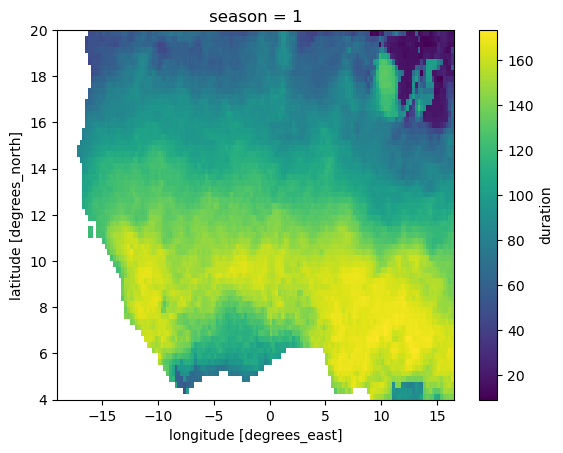

In [272]:
ds_seas_byyr.sel(**sp).sel(season=1).mean('year').duration.plot()

### Diagnostic

In [52]:
# Some durations were not calculated correctly

ds_seas.where(ds_seas.demise - 365 > ds_seas.duration.max()).stack(loc = ['lat','lon']).dropna('loc',how='all').isel(loc=6)

<xarray.Dataset> Size: 128B
Dimensions:       (season: 2)
Coordinates:
  * season        (season) int64 16B 1 2
    loc           object 8B (np.float32(35.875), np.float32(-83.375))
    lat           float32 4B 35.88
    lon           float32 4B -83.38
Data variables:
    avg_amount    (season) float64 16B 1.374 nan
    demise        (season) float64 16B 590.0 nan
    duration      (season) float64 16B 104.0 nan
    frac_totpr    (season) float32 8B 0.1105 nan
    onset         (season) float64 16B 329.0 nan
    peak_amount   (season) float32 8B 7.025 nan
    peak_timing   (season) float32 8B 357.0 nan
    total_amount  (season) float32 8B 142.9 nan

In [62]:
365 - np.abs(590-329)

np.int64(104)

In [26]:
(ds_seas.demise + 50).max().compute()

<xarray.DataArray 'demise' ()> Size: 8B
array(691.)

In [23]:
ds_seas.duration.max().compute()

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/dask/array/reductions.py:325: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


<xarray.DataArray 'duration' ()> Size: 8B
array(182.)

In [30]:
ds_seas.duration.max().compute()

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/dask/array/reductions.py:325: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


<xarray.DataArray 'duration' ()> Size: 8B
array(182.)

### Diagnostic figures

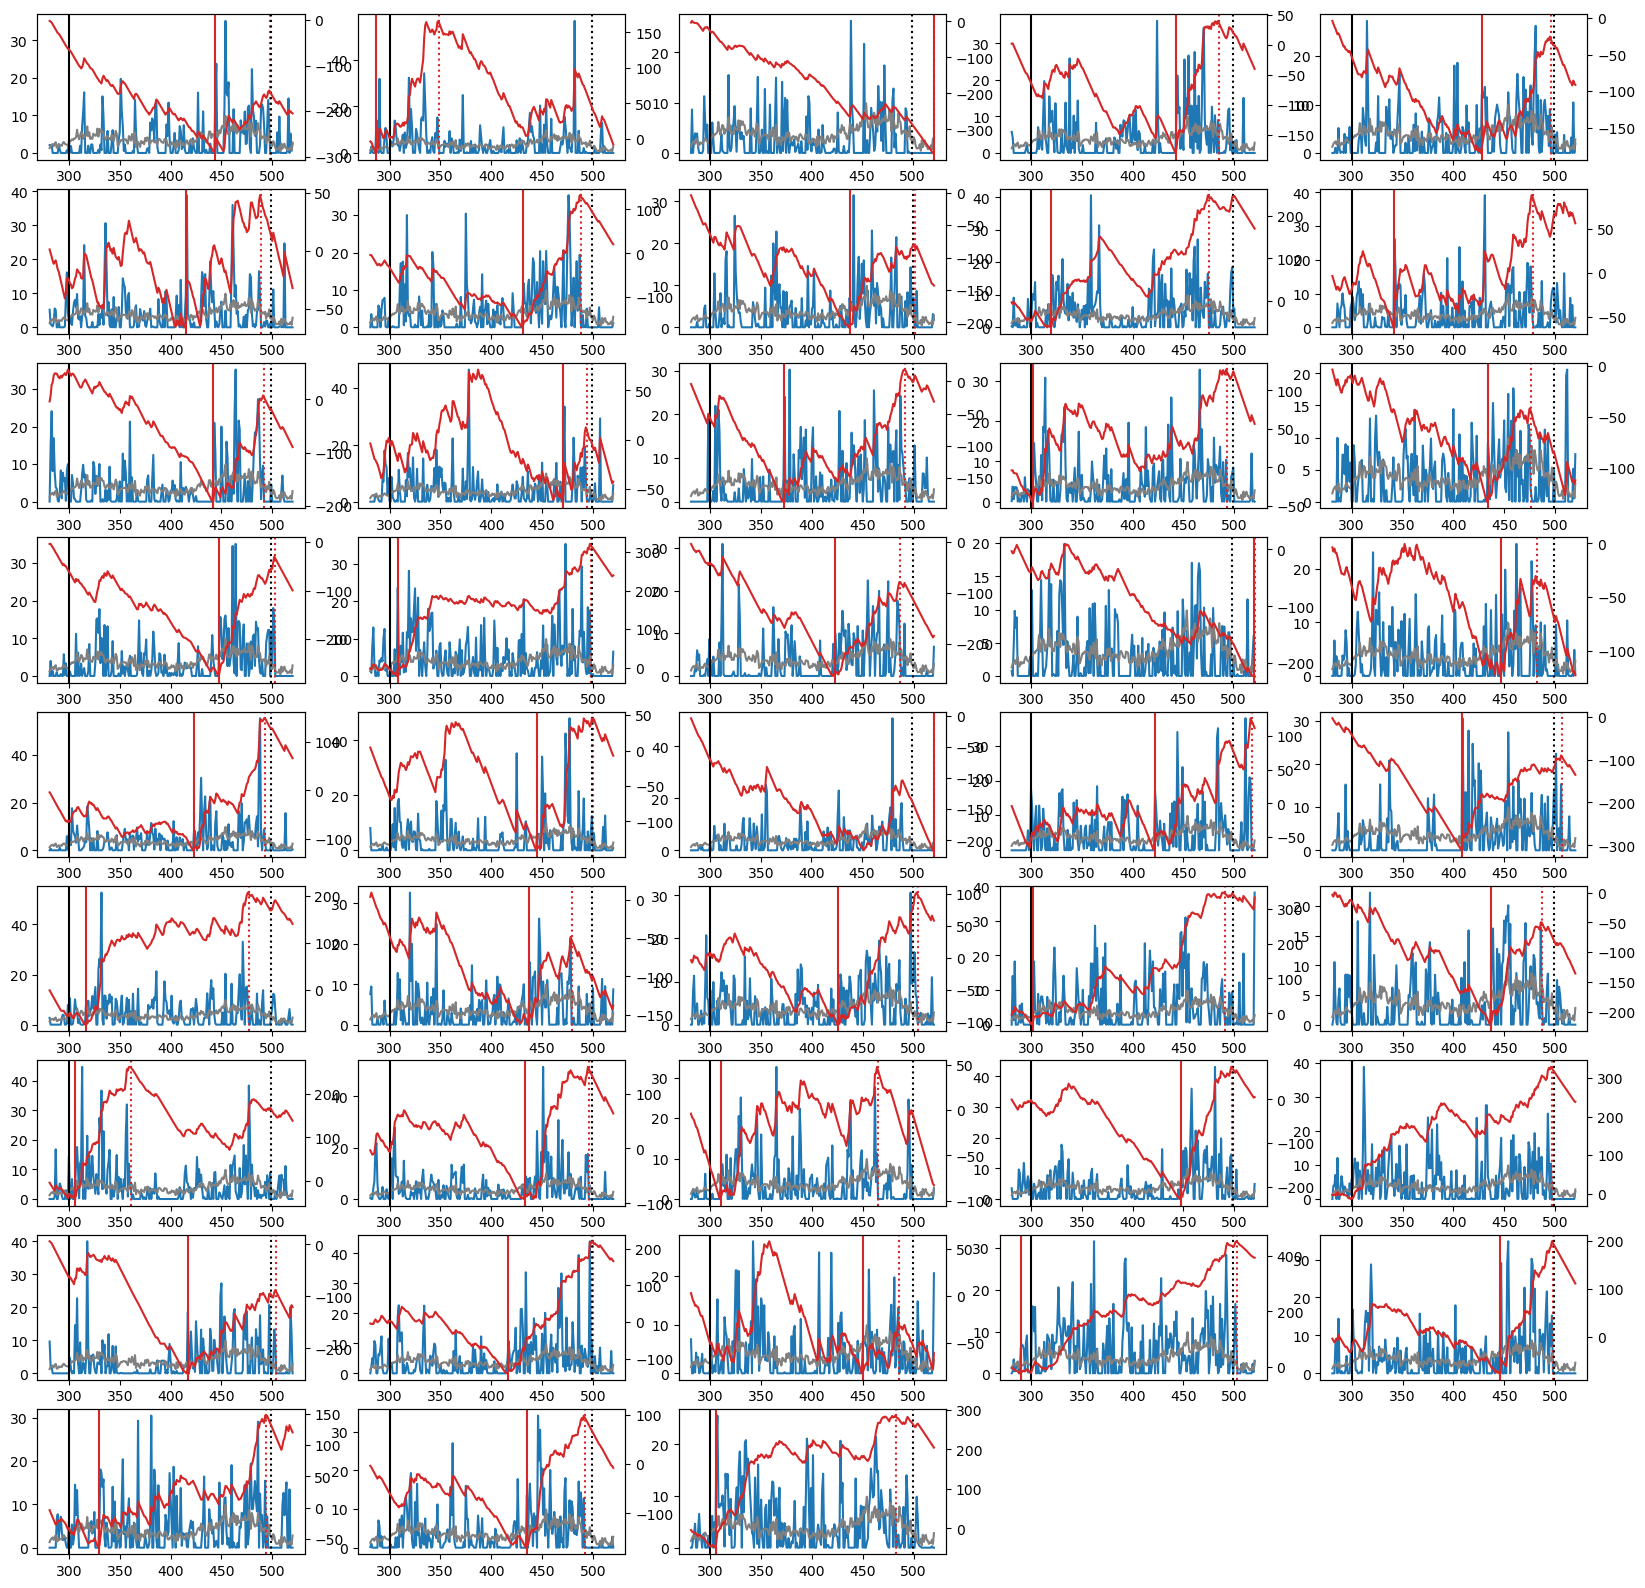

In [468]:
fig = plt.figure(figsize=(20,20))
for plt_idx in range(pr.shape[0]):
    ax = plt.subplot(9,5,plt_idx+1)
    plt.plot(doy,pr[plt_idx,:],color='tab:blue')

    plt.plot(doy,np.mean(pr,axis=0),color='grey')

    ax.axvline(onset[plt_idx],color='tab:red')
    ax.axvline(demise[plt_idx],color='tab:red',linestyle=':')

    ax.axvline(onset_lim,color='k')
    ax.axvline(demise_lim,color='k',linestyle=':')


    ax2 = ax.twinx()
    plt.plot(doy,A[plt_idx,:],color='tab:red')

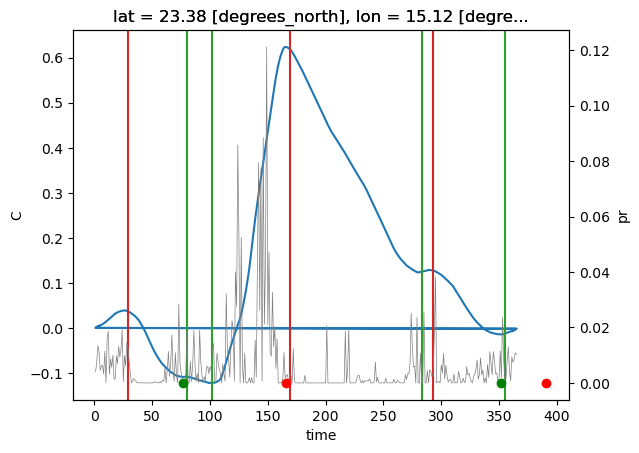

In [180]:
sp = {'lat':23.375,'lon':15.125}

ax = plt.subplot()
C.sel(**sp).plot()
for x in np.where(relmins.sel(**sp).values)[0]:
    ax.axvline(x,color='tab:green')
for x in np.where(relmaxs.sel(**sp).values)[0]:
    ax.axvline(x,color='tab:red')

ax2 = ax.twinx()
ds_doy.sel(**sp).pr.plot(color='grey',linewidth=0.5)
for seas_idx in range(ds_seas.sizes['season']):
    plt.plot([ds_seas.sel(**sp).isel(season = seas_idx).onset],[0],'go')
    plt.plot([ds_seas.sel(**sp).isel(season = seas_idx).demise],[0],'ro')

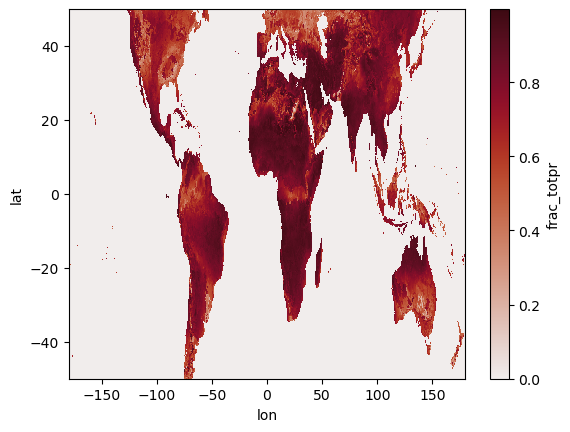

In [179]:
ds_seas.frac_totpr.sum('season').plot(cmap=cmocean.cm.amp)

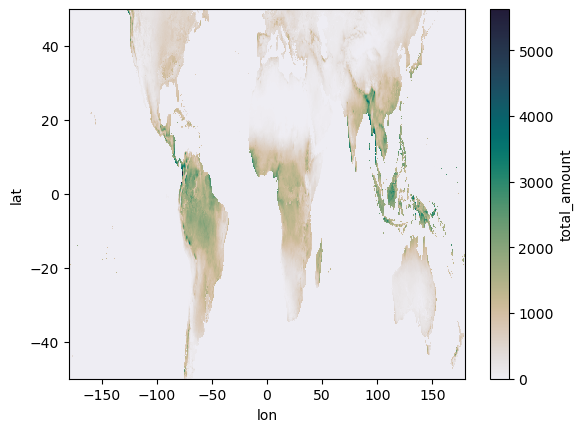

In [130]:
ds_seas.total_amount.sum('season').plot(cmap=cmocean.cm.rain)

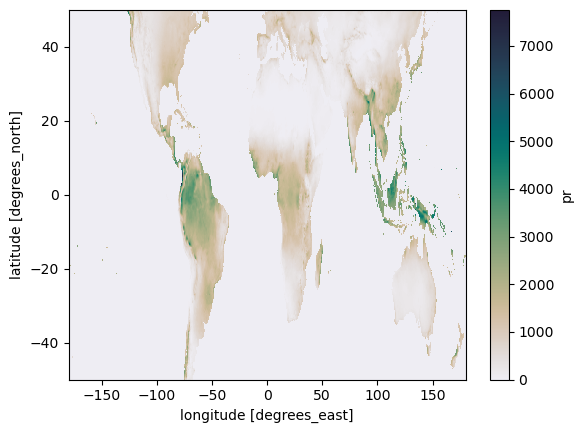

In [131]:
ds_doy.sum('dayofyear').pr.plot(cmap=cmocean.cm.rain)

In [126]:
for v in ['peak_timing','peak_amount','total_amount']:
    ds_seas[v] = xr.zeros_like(ds_seas['onset']*np.nan)
    
for seas_idx in ds_seas.season.values:

    # For readability, get onsets, demises for that season
    onsets,demises = ds_seas.sel(season=seas_idx).onset,ds_seas.sel(season=seas_idx).demise

    # Generate blank seasonal belonging flag
    inseas_flag = xr.zeros_like(ds_doy.pr)
    
    # Get seasonal belonging flag for non-wrap-around seasons
    inseas_flag = inseas_flag.where(((demises > onsets) & 
                                       ((inseas_flag.dayofyear<onsets) | 
                                       (inseas_flag.dayofyear>demises))),
                                      1)
    # Get seasonal belonging flag for wrap-around seasons
    inseas_flag = inseas_flag.where(((demises > onsets) | 
                                     ((demises < onsets) & 
                                       ((inseas_flag.dayofyear<onsets) &
                                       (inseas_flag.dayofyear>demises)))),
                                      1)
    
    # Day of peak rainfall 
    ds_seas['peak_timing'].loc[{'season':seas_idx}] = nan_argmax_xr(ds_doy.where(inseas_flag).pr,dim='dayofyear')
    # Amount of peak rainfall
    ds_seas['peak_amount'].loc[{'season':seas_idx}] = ds_doy.where(inseas_flag).pr.max('dayofyear')
    # Total rainfall in season
    ds_seas['total_amount'].loc[{'season':seas_idx}] = ds_doy.where(inseas_flag).pr.sum('dayofyear')

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.14/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 69.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-10-24 11:55:48,639 - distributed.worker - ERROR - Compute Failed
Key:       ('vectorize_wrapper_get_bimodal_stats-c833aa8c60cc6358c412862b8072cce4', 49, 57)
State:     executing
Task:  <Task ('vectorize_wrapper_get_bimodal_stats-c833aa8c60cc6358c412862b8072cce4', 49, 57) vectorize_wrapper_get_bimodal_stats(...)>
Exception: "ValueError('zero-size array to reduction operation minimum which has no identity')"
Traceback: '  File "/home/kschwarz/.conda/envs/aa_thresh/lib/python3.14/site-packages/numpy/lib/_function_base_impl.py", line 2544, in __call__\n    retur

ValueError: zero-size array to reduction operation minimum which has no identity

In [83]:
# Average rainfall / day in season
ds_seas['avg_amount'] = ds_seas['total_amount'] / ds_seas['duration']

In [88]:
# What fraction of total rainfall for this location falls during this season
ds_seas['frac_totpr'] = ds_seas['total_amount'] / ds_doy.pr.sum('dayofyear')

In [96]:
if 'units' in ds.pr.attrs:
    unit_attrs = {'units':ds.pr.attrs['units']}
else:
    unit_attrs = {}

# Metadata and housekeeping
ds_seas['onset'].attrs = {'long_name':'seasonal onset','units':'day of year'}
ds_seas['demise'].attrs = {'long_name':'seasonal demise','units':'day of year'}
ds_seas['duration'].attrs = {'long_name':'seasonal duration','units':'days'}
ds_seas['peak_timing'].attrs = {'long_name':'day of peak rainfall','units':'day of year'}
ds_seas['peak_amount'].attrs = {'long_name':'peak rainfall amount',**unit_attrs}
ds_seas['total_amount'].attrs = {'long_name':'summed rainfall in season'}
ds_seas['avg_amount'].attrs = {'long_name':'avg. rainfall in season',**unit_attrs}
ds_seas['frac_totpr'].attrs = {'long_name':'season as frac. of total rainfall',**unit_attrs}

ds_seas.attrs['SOURCE'] = 'calculate_seasstats.ipynb'
ds_seas.attrs['DESCRIPTION'] = 'seasonal statistics calculated using the methodology from Dunning et al., 2017'

### old diag code

In [386]:
relmins_stack = relmins.stack(locv = ['lat','lon'])
relmaxs_stack = relmaxs.stack(locv = ['lat','lon'])
seas_ratio_stack = seas_ratio.stack(locv=['lat','lon'])

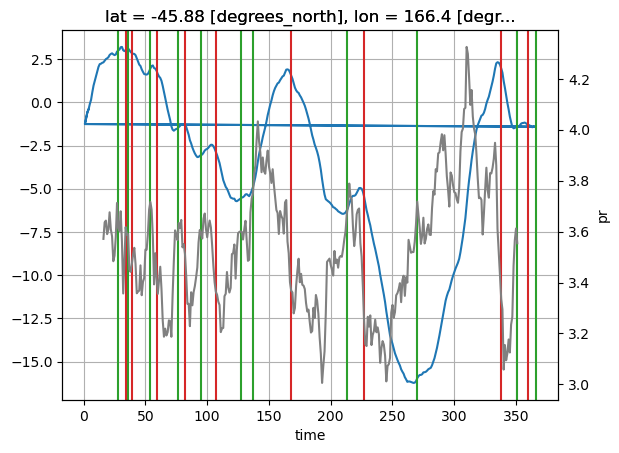

In [474]:
ax = plt.subplot()
C.sel({l:v for l,v in zip(['lat','lon'],tuple(np.atleast_1d(relmins_stack.locv[loc_idx].values))[0])}).plot()
for x in np.where(rlmins)[0]:
    ax.axvline(x,color='tab:green')
for x in np.where(rlmaxs)[0]:
    ax.axvline(x,color='tab:red')

ax.grid()

ax2 = ax.twinx()
(ds_doy.sel({l:v for l,v in zip(['lat','lon'],tuple(np.atleast_1d(relmins_stack.locv[loc_idx].values))[0])}).
    pr.rolling(dayofyear=wwidth,center=True).mean().plot(color='grey'))

In [ ]:
from tqdm import tqdm

for loc_idx in tqdm(np.arange(0,relmaxs_stack.sizes['locv'])):
    doy,rlmins,rlmaxs,sr = (relmins_stack.dayofyear.values,relmins_stack.isel(locv=loc_idx).values,
                            relmaxs_stack.isel(locv=loc_idx).values,seas_ratio_stack.isel(locv=loc_idx).values)
    wrapper_get_bimodal_stats(doy,
                              rlmins,
                              rlmaxs,
                              sr,
                              max_nseasons = 2)

In [15]:
import seaborn as sns

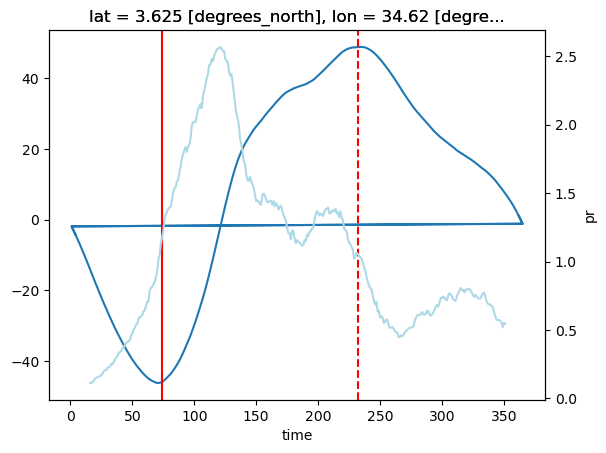

In [321]:
#subset_params = {'lat':-49.875,'lon':-74.375}
subset_params = {'lat':3.5,'lon':34.5,'method':'nearest'}
ax = plt.subplot()

C.sel(**subset_params).plot()
for seas_idx in np.arange(0,2):
    ax.axvline(out[0].sel(**subset_params).isel(season=seas_idx),color='k')
    ax.axvline(out[1].sel(**subset_params).isel(season=seas_idx),color='k',linestyle='--')
ax.axvline(ds_seas.onset.sel(**subset_params).isel(season=0),color='r')
ax.axvline(ds_seas.demise.sel(**subset_params).isel(season=0),color='r',linestyle='--')

ax2 = ax.twinx()
ds_doy.sel(**subset_params).rolling(dayofyear=wwidth,center=True).mean().pr.plot(color='lightblue')

In [306]:
np.abs(out[0].isel(season=0) - ds_seas.onset.isel(season=0)).stack(locv = ['lat','lon']).dropna('locv')[1]

<xarray.DataArray ()> Size: 8B
array(156.)
Coordinates:
    season   int64 8B 1
    locv     object 8B (np.float32(-49.875), np.float32(-74.375))
    lat      float32 4B -49.88
    lon      float32 4B -74.38

<Axes: xlabel='onset', ylabel='2seas'>

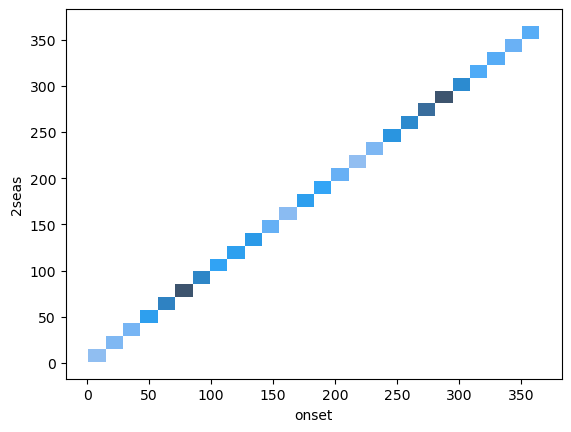

In [182]:
import seaborn as sns
sns.histplot(out[0].isel(season=0).to_dataframe(name='2seas').join(ds_seas.onset.isel(season=0).to_dataframe()),
            x='onset',y='2seas')

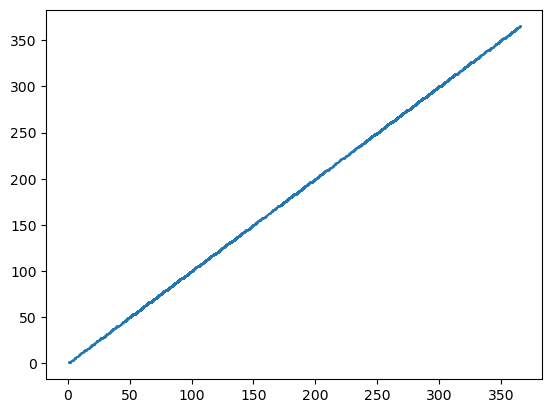

In [183]:
plt.scatter(out[0].isel(season=0),
            ds_seas.onset.isel(season=0),s=0.1)

## Old code

array([[280., 343.,  63.],
       [ 74., 138.,  64.]])

In [166]:
def wrapper_get_bimodal_stats(dayofyear,rlmins,rlmaxs,seas_ratio,max_nseasons = 2):
    if seas_ratio < 1:
        # Get onset / demise candidates as the days of year of relative
        # minima and maxima
        onset_candidates = dayofyear.where(rlmins, drop=True)
        demise_candidates = dayofyear.where(rlmaxs, drop=True)

        # Broadcast potential onsets / demises against each other
        candidate_pairs = xr.broadcast(onset_candidates.rename({'dayofyear':'onset'}),
                                       # Treat demises both explicitly, and one year into the future
                                       # to allow for seasons to wrap around the new year
                                     xr.concat([demise_candidates.rename({'dayofyear':'demise'}),
                                               (demise_candidates+365).rename({'dayofyear':'demise'})],
                                  dim='demise'))
        # Get duration of each onset / demise pair
        candidate_durations = (candidate_pairs[1] - candidate_pairs[0]).rename('duration')
        # Drop 'negative' durations (consequence of wraparound above)
        candidate_durations = candidate_durations.where(candidate_durations>0)
        
        # Select for each onset the next demise, wrapping if necessary
        seasons = candidate_durations.isel(demise=candidate_durations.argmin('demise'))
        
        # Get the longest max_nseasons seasons
        seasons = seasons[seasons.argsort()[0:max_nseasons].values]
        
        # Sort by onset to be in calendrical order
        seasons = seasons.sortby('onset')
        
        # Now turn into dataset with dimension season instead
        seasons = xr.Dataset({'onset': ('season', seasons['onset'].values.astype(int)),
                              'demise': ('season', seasons['demise'].values.astype(int)),
                              'duration': ('season', seasons.values.astype(int))},
                             coords={'season': np.arange(1,max_nseasons+1)})

        return seasons.onset,seasons.demise,seasons.duration

    else:
        # Otherwise, return a nan dataset
        seasons = xr.Dataset({'onset': ('season', [np.nan]*max_nseasons),
                              'demise': ('season', [np.nan]*max_nseasons),
                              'duration': ('season', [np.nan]*max_nseasons)},
                             coords={'season': np.arange(1,max_nseasons+1)})
        return seasons.onset,seasons.demise,seasons.duration

In [ ]:
def _calc_byyear_onset_demise(ds_byyr,ds_doy,ds_seas,single_peak_thresh):


    onsets,demises = xr.apply_ufunc(_calc_byyear_ufunc(ds_byyr.pr,
                                                       ds_doy.pr,
                                                       ds_doy.dayofyear,
                                                       ds_seas.onset,
                                                       ds_seas.demise,
                                                       peak_thresh,
                                                       input_core_dims = [['dayofyear','year'],['dayofyear','year'],['dayofyear'],[],[]],
                                                       output_core_dims = [[],[]],
                                                       vectorize=True,
                                                       dask = 'parallelized')

In [84]:
def _calc_byyear_onset_demise(ds_byyr,ds_doy,ds_seas,single_peak_thresh):
    '''
    Parameters
    -------------
    A : 

    ds_seas : 
        NOTE: do only one season
    '''

    A = (ds_byyr.pr - ds_doy.pr.mean('dayofyear'))

    # Subset to just the days of the year close to onsets / demises
    A = A.where(((A.dayofyear >= ds_seas.onset-single_peak_thresh) &
         (A.dayofyear <= ds_seas.demise+single_peak_thresh)))

    A = A.cumsum(dim='dayofyear')

    # Calculate onset / demise of single-peaked seasonal regions as just the 
    # min / max dayofyear of the cumulative anomaly
    ds_seas_byyr = xr.merge([(nan_argmin_xr(A,dim='dayofyear')+1).to_dataset(name='onset'),
                            (nan_argmax_xr(A,dim='dayofyear')+1).to_dataset(name='demise')])

    return ds_seas_byyr

In [ ]:
# First season
ds_seas_byyr = xr.where(ds_seas.sel(lat=slice(-3,12.5),lon=slice(32,55)).seas_ratio > 1,
                        _calc_byyear_onset_demise(ds_byyr,ds_doy,ds_seas.sel(season=1,drop=True),50),
                        _calc_byyear_onset_demise(ds_byyr,ds_doy,ds_seas.sel(season=1,drop=True),20))


# Turn into dataset structure, labeling these onset/demise dates as the 
# dates for the first season in one place, leaving season 2 blank
ds_seas_byyr = ds_seas_byyr.expand_dims({'season':[1,2]})
ds_seas_byyr = ds_seas_byyr.where(ds_seas.season==1)

# Second season
ds_seas_byyr.loc[{'season':2}] = _calc_byyear_onset_demise(ds_byyr.where(ds_seas.seas_ratio < 1),
                                                           ds_doy.where(ds_seas.seas_ratio < 1),
                                                            ds_seas.sel(season=2,drop=True),
                                                           20)

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 336.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [ ]:
onset,demise,duration=xr.apply_ufunc(wrapper_get_bimodal_stats,
                                     relmins.dayofyear,
                                       relmins,
                                       relmaxs,
                                       seas_ratio,
                                       input_core_dims = (['dayofyear'],
                                                          ['dayofyear'],
                                                          ['dayofyear'],
                                                          []),
                                        output_core_dims = [['season'],['season'],['season']],
                                       vectorize=True)

In [152]:
subset_params = {'lat':3,'lon':10,'method':'nearest'}

wrapper_get_bimodal_stats(relmins.sel(**subset_params),
                          relmaxs.sel(**subset_params),
                          seas_ratio.sel(**subset_params))

<xarray.Dataset> Size: 64B
Dimensions:   (season: 2)
Coordinates:
  * season    (season) int64 16B 1 2
Data variables:
    onset     (season) int64 16B 87 223
    demise    (season) int64 16B 165 319
    duration  (season) int64 16B 78 96

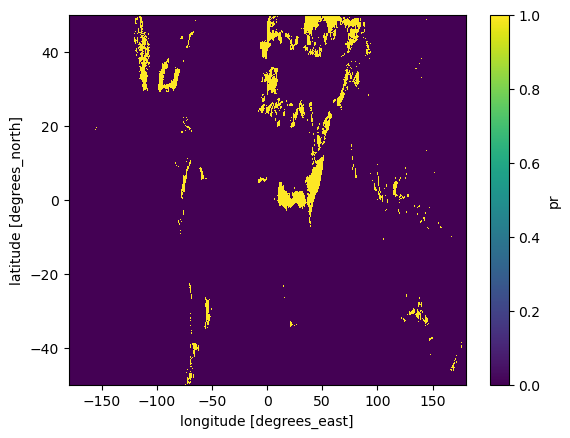

In [145]:
(np.abs(fft)<1).plot()

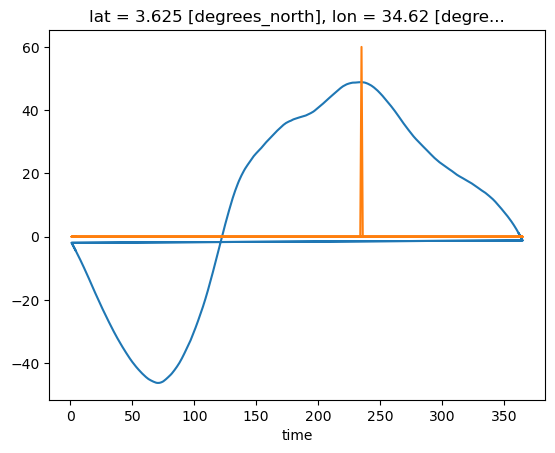

In [135]:
c = C.sel(lat=3.5,lon=34.5,method='nearest')

n = 4
c.plot()
((c == c.rolling(dayofyear=2*n+1,center=True).max())*60).plot()

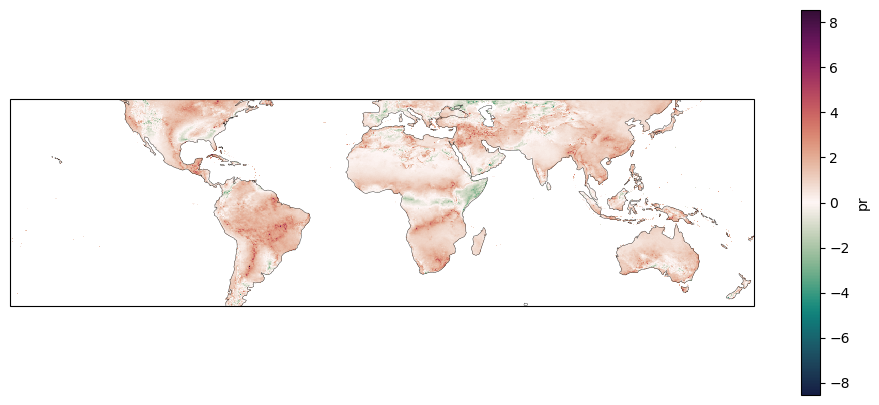

In [21]:
fig =plt.figure(figsize=(12,5))
ax = plt.subplot(projection=ccrs.PlateCarree())
np.log(np.abs(fft)).plot(cmap=cmocean.cm.curl,transform=ccrs.PlateCarree())
ax.coastlines(linewidth=0.25)